 ## Basic Data Exploration and Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Data Loading
df = pd.read_csv("train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


First, we convert the values to `uint8`. By default, the `pandas.read_csv()` function loads integers as `int64`, which uses 8 bytes per number. However, grayscale pixel values range from 0 to 255 → so `uint8` (1 byte) is sufficient.

This way, we can save storage space:

In [7]:
print(f"Memory size (int64): {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Convert all columns to uint8
df = df.astype('uint8')

# Verify data types and memory usage
print(df.dtypes)

print(f"Memory size (uint8): {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Memory size (int64): 8.98 MB
label       uint8
pixel1      uint8
pixel2      uint8
pixel3      uint8
pixel4      uint8
            ...  
pixel780    uint8
pixel781    uint8
pixel782    uint8
pixel783    uint8
pixel784    uint8
Length: 785, dtype: object
Memory size (uint8): 1.12 MB


In [8]:
# Separating the target variable (label) and input features (pixels)
X = df.drop("label", axis=1).values
y = df["label"].values

print(f"X size: {X.shape}")
print(f"y size: {y.shape}")

X size: (1500, 784)
y size: (1500,)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, label to pixel784
dtypes: uint8(785)
memory usage: 1.1 MB


In [10]:
df.iloc[:, 1:].min().min(), df.iloc[:, 1:].max().max()  # Min a Max pixels's values

(np.uint8(0), np.uint8(255))

The dataset contains 1,500 image samples with a resolution of 28×28 pixels in grayscale. The first column contains the class label, and the remaining columns represent the values of individual pixels.

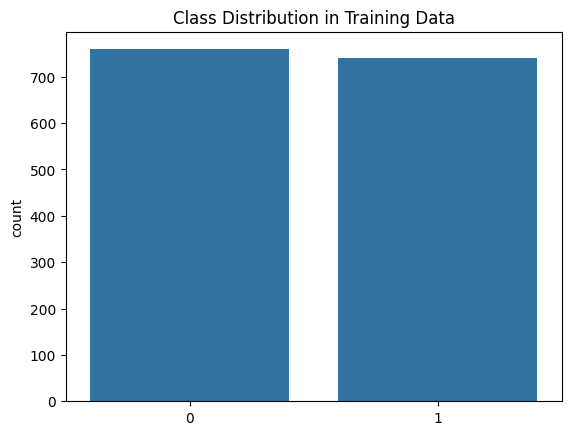

0 missing values


In [11]:
# Checking class distribution
sns.countplot(x=y)
plt.title("Class Distribution in Training Data")
plt.show()

# Checking for missing values
print(df.isnull().sum().sum(), "missing values")

From this, we can see that the dataset contains no missing values, and the classes in the target variable are balanced — each class has approximately the same number of samples, which is beneficial for training the models.

Let’s take a look at the images:

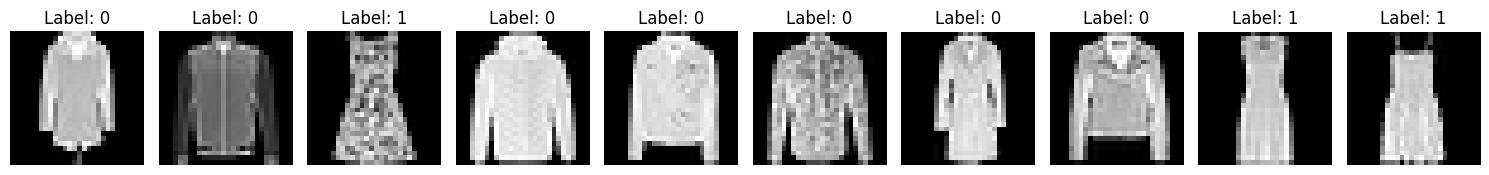

In [12]:
def plot_images(X, y, n=10):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X, y)

Next, we split the dataset into subsets. We divide it so that 70% is training data, 15% validation, and 15% testing.

In [13]:
from sklearn.model_selection import train_test_split

# Split into training and (validation + test) data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train.shape)  # Verify training subset size
display(y_train.shape)

# Split remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
display(X_val.shape)  # Verify validation and test subset sizes
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)

(1050, 784)

(1050,)

(225, 784)

(225,)

(225, 784)

(225,)

## Support Vector Machine (SVM)

SVM is a suitable choice for this task due to its ability to handle high-dimensional and potentially non-linearly separable data.

Jackets and dresses have visually similar features — both cover the upper body and may have similar shapes. Distinguishing between them is therefore not trivial. An SVM with a nonlinear kernel (e.g., RBF) can create a complex decision boundary that separates these classes better than simple linear models.

Let’s proceed to tune the hyperparameters:

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

# Define parameter grid for two different kernels
param_grid = [
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': ['scale', 0.01, 0.001]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 0.01, 0.001]
    }
]

# GridSearch with 5-fold cross-validation
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid.best_params_)
best_params = grid.best_params_

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [15]:
# Train the model with best_params
svm = SVC(**best_params)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)

# Print results
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(y_train, svm.predict(X_train))))
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(y_val, y_pred)))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Accuracy score (train): 0.974286
Accuracy score (validation): 0.946667

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       130
           1       0.93      0.95      0.94        95

    accuracy                           0.95       225
   macro avg       0.94      0.95      0.95       225
weighted avg       0.95      0.95      0.95       225



Based on the results, we can draw the following conclusions:

1. The accuracy on the validation dataset (0.947) is very good, indicating that the model generalizes well and does not just memorize the training data but performs effectively on new, unseen data.

2. The classification report shows high Precision and Recall for both classes (0 and 1), meaning the model accurately identifies true examples and minimizes misclassification between classes.

3. The F1-score is also high for both classes (0.95 and 0.94), reflecting a strong balance between precision and recall.

## Naive Bayes Classifier

Naive Bayes is a model commonly used for simple classification tasks and has several advantages:

* It is extremely fast and computationally efficient.
* Easy to implement and requires little parameter tuning.
* Highly interpretable.
* Works well even on small datasets.

However, it also has important limitations that are noticeable in our task:

* It assumes naive independence of features, meaning each pixel contributes to the decision independently of others. This is unrealistic for images—for example, neighboring pixels often form a coherent part (like the shape of a sleeve or shading).
* It does not consider the spatial structure of the image—each pixel is treated simply as a number.

For our Fashion MNIST dataset, where images are represented by pixel intensity values (continuous data), `Gaussian Naive Bayes` is clearly more appropriate than `Multinomial Naive Bayes`. The multinomial variant would be suitable only if we transformed the data into discrete counts (e.g., via binarization or quantization), which we did not do and is unnatural for visual data. To verify the results, we will test both variants.

In [16]:
from sklearn.naive_bayes import GaussianNB

# Reasonable range for var_smoothing (logarithmically spaced)
param_grid = {
    'var_smoothing': np.logspace(-9, -3, 7)
}

gnb = GaussianNB()
grid = GridSearchCV(gnb, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
gaus_best_params = grid.best_params_

gnb = GaussianNB(**gaus_best_params)

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_val)

# Print results
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(y_train, gnb.predict(X_train))))
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(y_val, y_pred)))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Best parameters: {'var_smoothing': np.float64(0.0001)}
Accuracy score (train): 0.890476
Accuracy score (validation): 0.888889

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       130
           1       0.81      0.97      0.88        95

    accuracy                           0.89       225
   macro avg       0.89      0.90      0.89       225
weighted avg       0.90      0.89      0.89       225



In [17]:
from sklearn.naive_bayes import MultinomialNB
# Train the model

param_grid = {'alpha': np.logspace(-2, 1, 10)}  # from 0.01 to 10.0 (logarithmically)

grid = GridSearchCV(MultinomialNB(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

multi_best_params = grid.best_params_

mult = MultinomialNB(**multi_best_params)

mult.fit(X_train, y_train)
y_pred = mult.predict(X_val)

# Print results
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(y_train, mult.predict(X_train))))
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(y_val, y_pred)))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Best parameters: {'alpha': np.float64(0.01)}
Accuracy score (train): 0.895238
Accuracy score (validation): 0.871111

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       130
           1       0.83      0.87      0.85        95

    accuracy                           0.87       225
   macro avg       0.87      0.87      0.87       225
weighted avg       0.87      0.87      0.87       225



Both models achieved comparable accuracy; however, Gaussian Naive Bayes slightly outperformed Multinomial on the validation set (0.889 vs. 0.871). It also had a higher F1-score, especially for class “1” (dress). This suggests that Gaussian NB, which handles continuous values like pixel intensities better, is more suitable for this task, as we initially expected.

## LDA – Linear Discriminant Analysis

LDA is suitable for our task because:

1. **Data dimensionality:** Fashion MNIST has a high number of input variables (784 pixels). LDA can reduce the data dimensionality while preserving as much discriminative information between classes as possible, which improves both efficiency and classification accuracy.

2. **Assumptions of normality and equal covariance matrices:** Although these assumptions may not be perfectly met in practice, LDA is robust to slight violations and works well in problems where classes are linearly or nearly linearly separable.

3. **High performance in binary classification:** Our task is a binary classification problem, where LDA often performs very effectively.

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Define shrinkage values including 'auto' and a range from 0.1 to 0.9
shrinkage_values = ['auto'] + list(np.arange(0.1, 1.0, 0.1))

param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': shrinkage_values
}

lda = LinearDiscriminantAnalysis()
grid = GridSearchCV(lda, param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

lda_best_params = grid.best_params_

lda = LinearDiscriminantAnalysis(**lda_best_params)

lda.fit(X_train, y_train)
y_pred = lda.predict(X_val)

# Output results
print('Accuracy score (train): {0:.6f}'.format(accuracy_score(y_train, lda.predict(X_train))))
print('Accuracy score (validation): {0:.6f}'.format(accuracy_score(y_val, y_pred)))

print("\nClassification report:")
print(classification_report(y_val, y_pred))

Best parameters: {'shrinkage': np.float64(0.6), 'solver': 'lsqr'}
Accuracy score (train): 0.964762
Accuracy score (validation): 0.906667

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       130
           1       0.86      0.93      0.89        95

    accuracy                           0.91       225
   macro avg       0.90      0.91      0.91       225
weighted avg       0.91      0.91      0.91       225



LDA achieved very good results on our task. The best results were obtained with the settings `solver='lsqr'` and `shrinkage=0.6`, which confirms the appropriateness of regularization for our data.

The F1-score for both classes is balanced and high, indicating that the model handles both categories well.

From the classification report, we can see that:

Class 0 (likely jacket) has higher precision, while

Class 1 (likely dress) has higher recall.

This means the model more often correctly detects dresses but occasionally confuses other images as dresses. Overall, it achieves a very solid performance.

### Data Generation with LDA

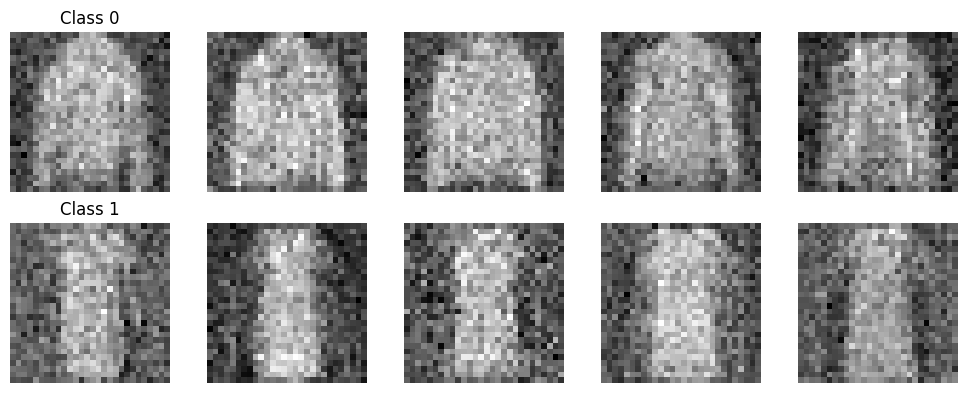

In [19]:
# For each class, generate 5 points
generated_images = []

for i, class_label in enumerate(lda.classes_):
    mean = lda.means_[i]  # average vector of pixel values for the class
    cov = lda.covariance_  # covariance matrix
    
    # Generate 5 samples from a multivariate normal distribution
    samples = np.random.multivariate_normal(mean, cov, 5)
    
    # Save for display
    generated_images.append((class_label, samples))

# Plot images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for row, (label, images) in enumerate(generated_images):
    for col in range(5):
        axs[row, col].imshow(images[col].reshape(28, 28), cmap='gray')
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Class {label}' if col == 0 else "")

plt.tight_layout()
plt.show()

The generated images look reasonable (they are realistic, diverse, and correspond to the class characteristics). We can observe the features: Dresses tend to have more short sleeves and a skirt shape at the bottom. Jackets have longer sleeves and are quite varied, but still retain the main characteristics.

This means that LDA models the data distribution well and can be used not only for classification but also for generative tasks.

## Dimensionality reduction - PCA, LLE

Next, we apply dimensionality reduction methods to each of our previous models with the best parameters. For LLE, we will try different numbers of neighbors.

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Models with best parameters
models = {
    'SVM': SVC(C=1, gamma='scale', kernel='rbf'),
    'LDA': LinearDiscriminantAnalysis(shrinkage=0.6, solver='lsqr'),
    'Naive Bayes': GaussianNB(var_smoothing=np.float64(0.0001))
}

# Function to apply dimensionality reduction and evaluate model accuracy
def evaluate_model_with_dimensionality_reduction(
    X_train, X_val, y_train, y_val, method, dims_range, model_name, neighbors_range=None
):
    results = {}  # Store (d, n_neighbors) -> accuracy
    
    for d in dims_range:
        if method == 'PCA': 
            pca = PCA(n_components=d)  # Initialize PCA with d components
            model = make_pipeline(pca, models[model_name])  # Create a pipeline with PCA and the model
            model.fit(X_train, y_train)  
            y_pred = model.predict(X_val) 
            acc = accuracy_score(y_val, y_pred)  
            results[(d,)] = acc
        elif method == 'LLE':  
            for n in neighbors_range:  # For each number of neighbors
                lle = LocallyLinearEmbedding(n_components=d, n_neighbors=n)  # Initialize LLE
                X_train_lle = lle.fit_transform(X_train)  # Apply LLE on training data
                X_val_lle = lle.transform(X_val)  # Apply LLE on validation data
                model = models[model_name]  # Select the model from defined models
                model.fit(X_train_lle, y_train) 
                y_pred = model.predict(X_val_lle) 
                acc = accuracy_score(y_val, y_pred)  
                results[(d, n)] = acc 
                
    return results

# Define range of dimensions for PCA and LLE 
dims = range(90, 201, 2) 

# Range for number of neighbors in LLE
neighbors_range = range(5, 21, 5)

# Results for PCA for all models
results_pca = {model_name: evaluate_model_with_dimensionality_reduction(X_train, X_val, y_train, y_val, 'PCA', dims, model_name) for model_name in models}

# Results for LLE for all models
results_lle = {
    model_name: evaluate_model_with_dimensionality_reduction(
        X_train, X_val, y_train, y_val, 'LLE', dims, model_name, neighbors_range
    )
    for model_name in models
}

In [21]:
# PCA – print best accuracy and number of components
print("Best results for PCA:")
for model_name, results in results_pca.items():
    best_params = max(results, key=results.get)
    best_acc = results[best_params]
    print(f"{model_name}: dimension = {best_params[0]}, accuracy = {best_acc:.4f}")

# LLE – print best accuracy, number of components, and number of neighbors
print("\nBest results for LLE:")
for model_name, results in results_lle.items():
    best_params = max(results, key=results.get)
    best_acc = results[best_params]
    print(f"{model_name}: dimension = {best_params[0]}, n_neighbors = {best_params[1]}, accuracy = {best_acc:.4f}")

Best results for PCA:
SVM: dimension = 90, accuracy = 0.9511
LDA: dimension = 126, accuracy = 0.9156
Naive Bayes: dimension = 126, accuracy = 0.9067

Best results for LLE:
SVM: dimension = 172, n_neighbors = 15, accuracy = 0.9333
LDA: dimension = 172, n_neighbors = 20, accuracy = 0.9333
Naive Bayes: dimension = 104, n_neighbors = 15, accuracy = 0.8933


From the results, we can see that the best model is ultimately the SVM after PCA with the selected dimension.

Additionally, let's visualize the performance trends when applying LLE and PCA.

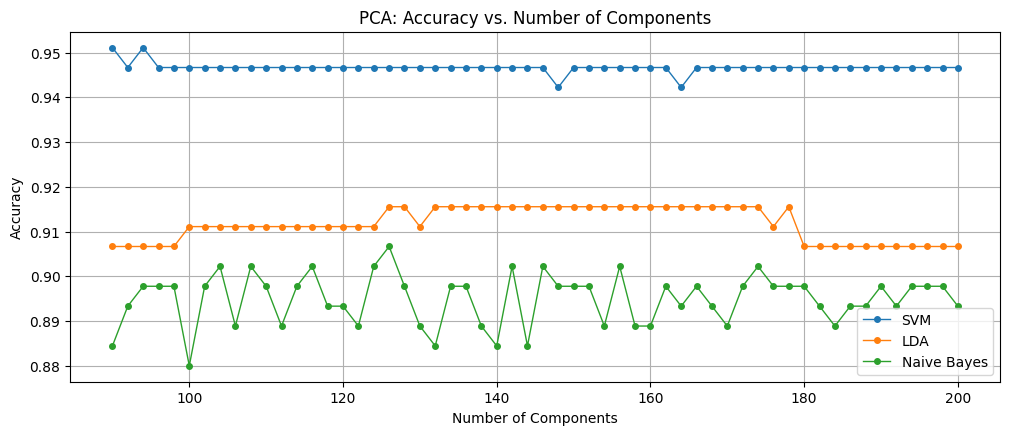

In [22]:
# === PCA plot ===
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for model_name, result_dict in results_pca.items():
    # Convert dictionary keys (d,) to sorted list of dimensions
    dims_sorted = sorted([k[0] for k in result_dict.keys()])
    accs = [result_dict[(d,)] for d in dims_sorted]
    plt.plot(dims_sorted, accs, label=model_name, marker='o', markersize=4, linewidth=1)
plt.title('PCA: Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

Let's create a 3D scatter plot for LLE

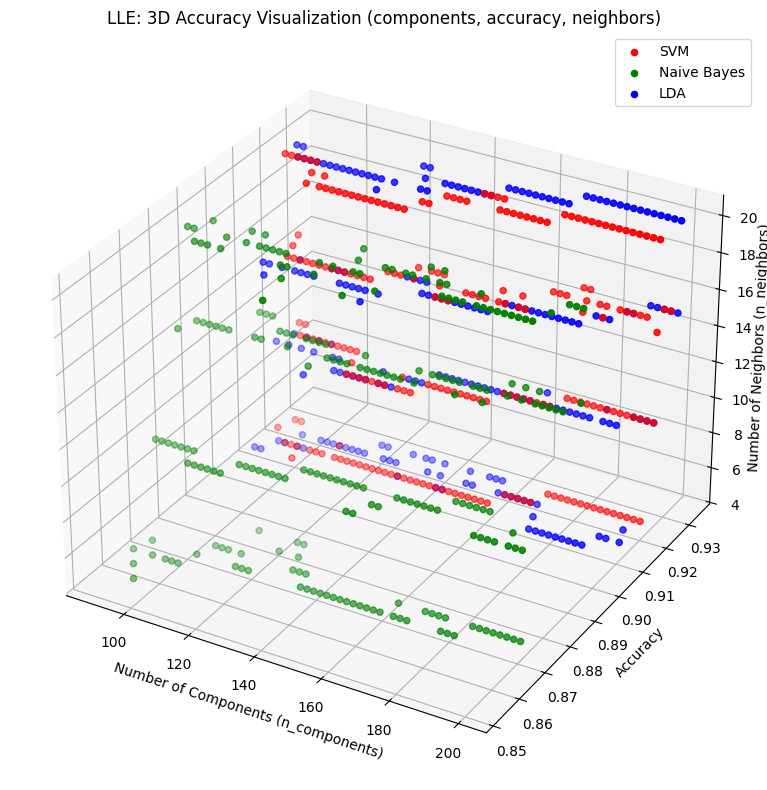

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {
    'SVM': 'red',
    'Naive Bayes': 'green',
    'LDA': 'blue'
}

# Plot points for each model
for model_name in ['SVM', 'Naive Bayes', 'LDA']:
    xs = []
    ys = []
    zs = []
    for (d, n), acc in results_lle[model_name].items():
        xs.append(d)      # components
        ys.append(acc)    # accuracy
        zs.append(n)      # n_neighbors
    ax.scatter(xs, ys, zs, label=model_name, color=colors[model_name])

ax.set_xlabel('Number of Components (n_components)')
ax.set_ylabel('Accuracy')
ax.set_zlabel('Number of Neighbors (n_neighbors)', labelpad=-2)
ax.set_title('LLE: 3D Accuracy Visualization (components, accuracy, neighbors)')
ax.legend()
plt.tight_layout()
plt.show()

## Applying the final model and saving the results

We will train the model with our best parameters and estimate its accuracy, which we can expect on new data.

In [24]:
pca = PCA(n_components=90)  # Initialize PCA with d components
best_model = make_pipeline(pca, SVC(C=1, gamma='scale', kernel='rbf'))  # Create a pipeline with PCA and the model
best_model.fit(X_train, y_train)  

print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(y_val, best_model.predict(X_val))))

# Check accuracy on the test data  
print('\nAccuracy score (test): {0:.6f}'.format(metrics.accuracy_score(y_test, best_model.predict(X_test))))

Accuracy score (validation): 0.951111

Accuracy score (test): 0.946667


So, we can expect an accuracy of 94%.

In [25]:
# Loading the data
ev = pd.read_csv("evaluate.csv")
ev.head()
X_eval = ev.drop("ID", axis=1).values
ids = ev["ID"].values

# Prediction using the best model
y_eval = best_model.predict(X_eval)

# Saving the results into a DataFrame
results = pd.DataFrame({
    "ID": ids,
    "label": y_eval
})

# Saving to a CSV file without the index
results.to_csv("results.csv", index=False)
results.head()


,ID,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
